# Catégorisez automatiquement des questions - Stack Overflow

#### Objectif: 
Développement d'un système de suggestion de tags via une API pour facilité la recherche aux utilisateurs sur le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.


Dans ce notebook:  
- Vectorisation 
- Entrainement des modèles 

### Sommaire

* [Import](#chapter1)
    * [Librairies](#section_1_1)
    * [Données](#section_1_2)
 
 
* [Les fonctions](#chapter2)
    * [Nettoyage](#section_2_1)
    * [Vectorization](#section_2_2)
    * [Représentation](#section_2_3)


* [Vectorization](#chapter3)
    * [Bag of Word & Tf idf](#section_3_1)
    * [Word Embeddings](#section_3_2)
        * [Word2Vect](#section_3_2_1)
        * [Bert](#section_3_2_2)
        * [USE](#section_3_2_3)  


* [Modélisation](#chapter4)
    * [Non supervisée: Latent Dirichlet Allocation](#section_4_1)
    * [Modélisation supervisée](#section_4_2)


## Import <a class="anchor" id="chapter1"></a>
### Librairies <a class="anchor" id="section_1_1"></a>

In [272]:
# Import des librairies
import numpy as np
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time

from collections import Counter

from bs4 import BeautifulSoup

# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

# Modélisation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import gensim

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [2]:
import tensorflow

In [62]:
#from tensorflow import *

In [3]:
#Word2Vec
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import tensorflow_hub as hub

In [4]:
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


In [116]:
#pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 221.1 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Nos données <a class="anchor" id="section_1_2"></a>

In [6]:
data = pd.read_csv('processed_data.csv')

In [7]:
data = data.drop(['Unnamed: 0'],axis=1)

In [8]:
data.shape 

(284, 11)

In [9]:
data.head(1)

,CreationDate,Title,Body,Tags,Text,Text_remove_duplicate,Cleaned_text,length_cleaned_text,body_tokens_count,number_of_tags,top_tags
0,2008-08-12 14:37:28,Can I get Memcached running on a Windows (x64)...,"<p>Does anyone know <strong>IF</strong>, <stro...","c#,c++,windows,64-bit,memcached",Can I get Memcached running on a Windows (x64)...,can i get memcached running on a windows envir...,get memcached run window environment anyone kn...,194,194,3,"c#, c++, windows"


In [12]:
data["Tags"].nunique()

284

## Fonctions <a class="anchor" id="chapter2"></a>
### Nattoyages <a class="anchor" id="section_2_1"></a>

In [190]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def remove_code(html):
    # parse html content
    soup = BeautifulSoup(html, "html.parser")  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()  
    # return data by retrieving the tag content
    return soup.stripped_strings

def regex(text):
    
    # Remove html tags
    text=re.sub(r"<[^>]*>",' ', text)
    # Remove usernames "@"
    text=re.sub(r'@\S+', ' ', text)
    # Remove hashtags
    text=re.sub(r'#\S+', ' ', text)
    # Remove punctuation
    text=re.sub(r'[^\w\s]', ' ', text)
    # Remove unicode characters
    text = text.encode("ascii", "ignore").decode()
    # Remove irrelevant characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove English contractions
    text = re.sub("\'\w+", '', text)
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    # Remove numbers
    text = re.sub(r'\w*\d+\w*', '', text)
    # Remove links
    text = re.sub(r'http*\S+', '', text)
    # Remove whitespace
    text=re.sub(r'^\s*|\s\s*', ' ', text).strip()
    text=text.replace('\n', '')
    
    return text

def remov_duplicates(input):
 
    # split input string separated by space
    input = input.split(" ")
 
    # now create dictionary using counter method
    # which will have strings as key and their
    # frequencies as value
    UniqW = Counter(input)
 
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    
    return s

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Remove single character
def remove_single_char_func(text, threshold=1):
    threshold = threshold
    words = word_tokenize(text)
    text = ''.join([w for w in words if len(w) > threshold])
    return text

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


### Préparation pour la vectorization <a class="anchor" id="section_2_2"></a>

In [181]:
# Fonction de preparation du text pour la vectorization bag of word, Tf idf et Word2Vec

def transform_bow_fct(desc_text) :
    text_regex = regex(desc_text.lower())
    text_remove_duplicated = remov_duplicates(text_regex)
    word_tokens = tokenizer_fct(text_remove_duplicated)
    sw = stop_word_filter_fct(word_tokens)
    lem_w = lemma_fct(sw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [196]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    text_regex = regex(desc_text.lower())
    text_remove_duplicated = remov_duplicates(text_regex)
    word_tokens = tokenizer_fct(text_remove_duplicated)
    transf_desc_text = ' '.join(word_tokens)
    return transf_desc_text

### Représentation graphique <a class="anchor" id="section_2_2"></a>

In [252]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des questions par tags')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des questions par clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [186]:
data['Cleaned_text'] = data['Cleaned_text'].astype("string")

In [187]:
data['Text'] = data['Text'].astype("string")

In [197]:
data['sentence_bow'] = data['Text'].apply(lambda x : transform_bow_fct(x))
data['sentence_dl'] = data['Text'].apply(lambda x : transform_dl_fct(x))
data.shape

(284, 16)

In [198]:
from nltk.tokenize import sent_tokenize, word_tokenize

data['length_bow'] = data['sentence_bow'].apply(lambda x : len(word_tokenize(str(x))))
max_length_bow = data['length_bow'].max()
print("max length bow : ", max_length_bow)

data['length_dl'] = data['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
max_length_dl = data['length_dl'].max()
print("max length dl : ", max_length_dl)

max length bow :  219
max length dl :  288


In [199]:
print(data[data['length_dl']==1076]['sentence_dl'])
data['sentence_dl'][171]

Series([], Name: sentence_dl, dtype: object)


'how to make generic computations over heterogeneous argument packs of a variadic template function premise after playing around with templates little bit i realized that achieving anything which goes slightly beyond the trivial meta programming tasks soon becomes pretty cumbersome in particular found myself wishing for way perform operations an pack such as iterate split loop std each like fashion and so on watching this lecture by andrei alexandrescu from c desirability static if into construct borrowed d language had feeling some sort would come handy well feel more these constructs could bring benefit started wondering there is achieve something pseudo code lt typename ts gt void my amp args int sizeof foo nth value get translated at compile time principle allow even elaborate processing constexpr s do different bar or expressive idiom one auto x related work did search web out does indeed exist link describes convert parameter boost mpl vector but only half not less towards goal q

In [202]:
data['length_text_brut'] = data['Text'].apply(lambda x : len(word_tokenize(str(x))))
max_length_data_brut = data['length_text_brut'].max()
print("max length Text : ", max_length_data_brut)

max length Text :  1051


In [203]:
data['length_cleaned_text'] = data['Cleaned_text'].apply(lambda x : len(word_tokenize(str(x))))
max_length_cleaned_data = data['length_cleaned_text'].max()
print("max length Cleaned_text : ", max_length_cleaned_data)

max length Cleaned_text :  221


## Vectorization <a class="anchor" id="chapter3"></a>
### Bag of word & Tf-idf <a class="anchor" id="section_3_1"></a>

In [205]:
data.head(2)

,CreationDate,Title,Body,Tags,Text,Text_remove_duplicate,Cleaned_text,length_cleaned_text,body_tokens_count,number_of_tags,top_tags,sentence_bow,sentence_dl,length_bow,length_dl,length_text,length_text_brut
0,2008-08-12 14:37:28,Can I get Memcached running on a Windows (x64)...,"<p>Does anyone know <strong>IF</strong>, <stro...","c#,c++,windows,64-bit,memcached",Can I get Memcached running on a Windows (x64)...,can i get memcached running on a windows envir...,get memcached run window environment anyone kn...,194,194,3,"c#, c++, windows",get memcached running window bit environment a...,can i get memcached running on a windows x bit...,191,273,892,892
1,2008-08-22 03:12:59,How Do You Communicate Service Layer Messages/...,<p>I'm currently writing an ASP.Net app from t...,"c#,asp.net,exception,mvp,n-tier-architecture",How Do You Communicate Service Layer Messages/...,how do you communicate service layer messages ...,communicate service layer message error high l...,185,185,2,"c#, asp.net",communicate service layer message error higher...,how do you communicate service layer messages ...,182,254,816,816


In [207]:
data['top_tags'].value_counts()

python                                                   13
java                                                     10
c#, .net                                                 10
javascript                                                8
android                                                   8
                                                         ..
asp.net                                                   1
c#, asp.net-mvc, caching, architecture, asp.net-mvc-3     1
c#, asp.net, deployment                                   1
java, spring, memory-leaks                                1
reactjs, macos                                            1
Name: top_tags, Length: 168, dtype: int64

In [290]:
# Preparation des données:

X=data['sentence_bow']
y=data['top_tags']

In [242]:
l_cat = list(set(data['top_tags']))
print("catégories : ", l_cat)

catégories :  ['python, ssl', 'c++, assembly, concurrency', 'android', 'c++, python', 'c#, .net, memory-leaks', 'c++, c++11', 'php, html', 'java, performance, multithreading', 'iphone, ios', 'objective-c, cocoa', 'java, android', 'c#, android, .net, asp.net-mvc', 'php, ruby, architecture', 'c#, c++, windows', 'iphone, android, rest, restful-authentication', 'c++, c', 'caching', 'c++, algorithm, multithreading, concurrency', 'node.js, caching', 'c#, ios', 'java, database, scala', 'java, rest', 'php, image', 'security, authentication', '.net, javascript', 'ruby-on-rails, ruby', 'java, database, spring', 'c#, ios, multithreading', 'django', 'javascript, node.js', 'javascript, image, memory-leaks', '.net', 'c++', 'asp.net-mvc, asp.net-mvc-3', 'android, python', 'php, security', 'java, macos', 'ios, iphone, objective-c', 'sql, database', 'django, concurrency', 'php, algorithm, rest', 'python', 'android, iphone, ios', '.net, architecture', 'javascript, html', 'c#, asp.net-mvc, caching, archi

In [251]:
y_cat_num = [(1-l_cat.index(data.iloc[i]['top_tags'])) for i in range(len(data))]

In [253]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(analyzer="word", stop_words='english', max_df=0.6, min_df=0.005)
ctf = TfidfVectorizer(analyzer="word", stop_words='english', max_df=0.6, min_df=0.005)


cv_fit = cvect.fit(X)
ctf_fit = ctf.fit(X)

X_BoW = cvect.transform(X)  
X_tfidf = ctf.transform(X)  

In [269]:
print("Shape of y: {}".format(y.shape))
print("Shape of X for the Title&Text in BoW: {}".format(X_BoW.shape))
print("Shape of X for Title&Text in Tf-idf: {}".format(X_tfidf.shape))

Shape of y: (284,)
Shape of X for the Title&Text in BoW: (284, 3684)
Shape of X for Title&Text in Tf-idf: (284, 3684)


In [255]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(X_BoW)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(X_tfidf)

CountVectorizer : 
-----------------
ARI :  0.032 time :  4.0

Tf-idf : 
--------
ARI :  0.0479 time :  3.0


In [256]:
full_dense = X_tfidf.todense()
print("Full_doc sparsicity tf idf: {:.3f} %"\
      .format(((full_dense > 0).sum()/full_dense.size)*100))

Full_doc sparsicity tf idf: 3.223 %


In [257]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(X_BoW)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(X_tfidf)

CountVectorizer : 
-----------------
ARI :  0.032 time :  4.0

Tf-idf : 
--------
ARI :  0.0479 time :  4.0


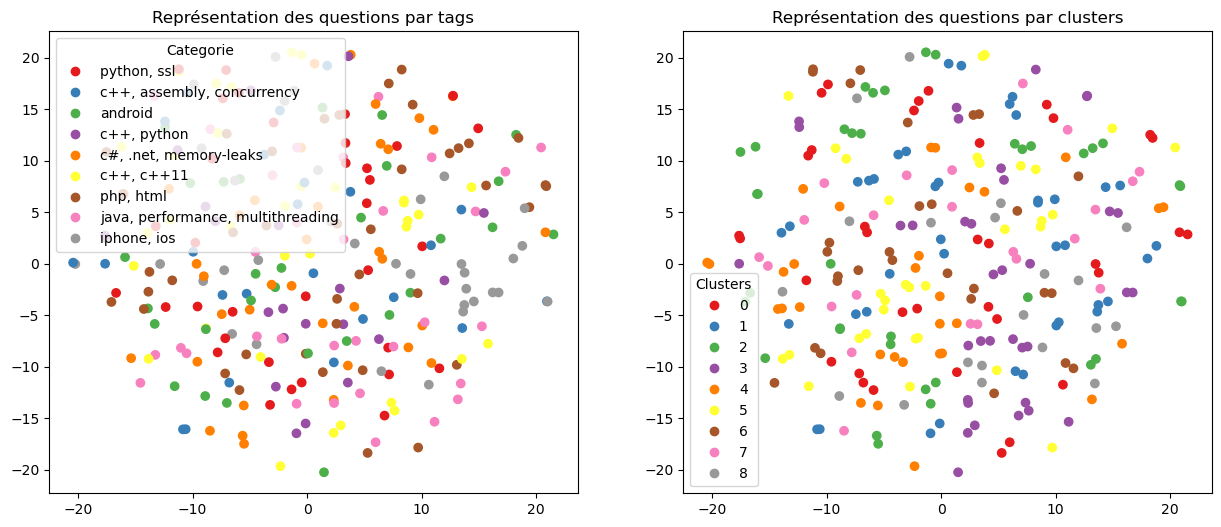

ARI :  0.0479


In [258]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [277]:
y.value(counts)

0             c#, c++, windows
1                  c#, asp.net
2                         java
3            .net, performance
4                         .net
                ...           
279                        c++
280                     django
281                 javascript
282                     python
283    android, android-studio
Name: top_tags, Length: 284, dtype: object

In [345]:
# Multilabel binarizer for targets

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(data['top_tags'].str.split(', '))

print(" Les différent sujets sont: \n{}".format(mlb.classes_))
print('\n')
print("Shape of y: {}".format(y_binarized2.shape))

 Les différent sujets sont: 
['.net' 'algorithm' 'android' 'android-studio' 'angularjs' 'architecture'
 'asp.net' 'asp.net-mvc' 'asp.net-mvc-3' 'assembly' 'authentication' 'c'
 'c#' 'c++' 'c++11' 'caching' 'cocoa' 'concurrency' 'css' 'database'
 'deployment' 'django' 'html' 'image' 'ios' 'iphone' 'java' 'javascript'
 'linux' 'macos' 'memory-leaks' 'multithreading' 'node.js' 'objective-c'
 'performance' 'php' 'postgresql' 'python' 'reactjs' 'rest'
 'restful-authentication' 'ruby' 'ruby-on-rails' 'scala' 'security'
 'spring' 'sql' 'ssl' 'web-applications' 'windows']


Shape of y: (284, 50)


In [346]:
df_y_binarized = pd.DataFrame(y_binarized2,columns=mlb2.classes_)
df_y_binarized

,.net,algorithm,android,android-studio,angularjs,architecture,asp.net,asp.net-mvc,asp.net-mvc-3,assembly,...,restful-authentication,ruby,ruby-on-rails,scala,security,spring,sql,ssl,web-applications,windows
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [359]:
# Create train and test split (30%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_BoW, y_binarized,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (227, 3684)
X_test shape : (57, 3684)
y_train shape : (227, 50)
y_test shape : (57, 50)


In [352]:
# Create train and test split (30%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (227, 3684)
X_test shape : (57, 3684)
y_train shape : (227, 50)
y_test shape : (57, 50)


In [360]:
full_dense = X_BoW.todense()
print("Full_doc sparsicity: {:.3f} %"\
      .format(((full_dense > 0).sum()/full_dense.size)*100))

Full_doc sparsicity: 3.223 %


Metriques :  
Accuracy score  
F1 score  
Jaccard similarity score  
Recall  
Precision

In [ ]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

## Words Embeddings <a class="anchor" id="section_3_2"></a>

### Word2Vec <a class="anchor" id="section_3_2_1"></a>

In [361]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = max_length_bow # adapt to length of sentences

sentences = data['sentence_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [362]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
# workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 8659
Word2Vec trained


In [363]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 8660


In [364]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (8660, 300)


In [409]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.20384693,  0.67470729,  1.40380728, ...,  0.52364242,
         0.37800911, -0.88323641],
       [-0.77565908,  1.77935266, -1.17736769, ...,  0.58718884,
         0.10105716,  0.82824707],
       ...,
       [ 0.00735289,  0.01159873,  0.02394389, ...,  0.1049862 ,
        -0.03737091,  0.04872173],
       [-0.02381345,  0.00545575, -0.00679976, ...,  0.06048469,
        -0.03767527,  0.04117204],
       [-0.00736022, -0.15951733, -0.0662808 , ..., -0.02326065,
        -0.05082798,  0.0067618 ]])

In [365]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')

word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)

word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

2022-11-05 17:59:05.903873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 219)]             0         
                                                                 
 embedding (Embedding)       (None, 219, 300)          2598000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 2,598,000
Trainable params: 2,598,000
Non-trainable params: 0
_________________________________________________________________


In [366]:
# Exécution du modèle
embeddings = embed_model.predict(x_sentences)
embeddings.shape

9/9 [==============================] - 2s 5ms/step


(284, 300)

In [367]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0072 time :  4.0


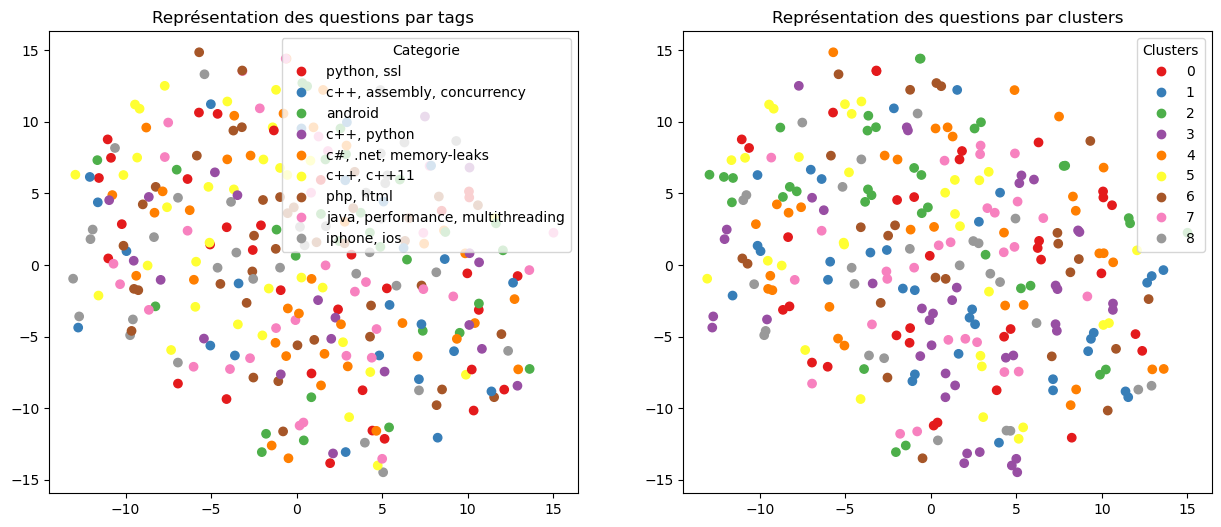

ARI :  0.0072


In [368]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### BERT <a class="anchor" id="section_3_2_2"></a>

#### Les Fonctions

In [37]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### BERT HuggingFace

In [129]:
pip install --upgrade torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 MB 56.9 kB/s eta 0:00:0000:0102:41
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.9 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2
Note: you may need to restart the kernel to use updated packages.


In [35]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type,from_pt=True)

2022-10-30 13:44:23.067631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
sentences = data['sentence_dl'].to_list()

In [38]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Downloading: 100%|███████████████████████████| 28.0/28.0 [00:00<00:00, 10.0kB/s]
Downloading: 100%|████████████████████████████| 226k/226k [00:00<00:00, 370kB/s]
Downloading: 100%|████████████████████████████| 455k/455k [00:02<00:00, 176kB/s]


1/1 [==============================] - 1s 966ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


KeyboardInterrupt: 

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Universal Sentence Encoder <a class="anchor" id="section_3_2_3"></a>

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Fonction

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [23]:
pip install top2vec

     |████████████████████████████████| 5.2 MB 45 kB/s eta 0:00:014
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 45 kB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 86 kB/s eta 0:00:013
     |████████████████████████████████| 1.1 MB 217 kB/s eta 0:00:01
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp39-cp39-macosx_10_9_x86_64.whl size=657730 sha256=9f8275bc81c88148750a0202153bcfb7c1c5815ed7c95091ad53da5d9a93f516
  Stored in directory: /Users/Diana_1/Library/Caches/pip/wheels/97/2d/1e/d9907e8f806ee949f9effc41004d7f32e862f6f67d9157812d
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=5167e26f0c7ad0343cfce923e2a192c75c692fc30d0107ca5441bb4807dd55ba
  Stored in directory: /Users/Diana_1/Library/Caches/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndes

In [3]:
pip install https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.8.0-py3-none-any.whl

     |████████████████████████████████| 46.5 MB 488 kB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 98 kB/s eta 0:00:011
  Using cached termcolor-2.0.1-py3-none-any.whl (5.4 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
     |████████████████████████████████| 889 kB 773 kB/s eta 0:00:01
  Created wheel for html5lib: filename=html5lib-0.9999999-py3-none-any.whl size=107233 sha256=d8e2b64a40a49fa370ce81dbfcf87e6096b078250057373acaa5857736274aff
  Stored in directory: /Users/Diana_1/Library/Caches/pip/wheels/f5/09/3f/ff7233827f32dd8856574fd464fdc480892ecc575c6ce62145
Successfully built html5lib
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.1
    Uninstalling html5lib-1.1:
      Successfully uninstalled html5lib-1.1
  Attempting uninstall: bleach
    Found existing installation: bleach 4.0.0
    Uninstalling bleach-4.0.0:
      Successfully uninstalled bleach-4.0.0
Note: you may need to restart the kernel to use updated packages.


### USE <a class="anchor" id="section_3_2_3"></a>

In [74]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [76]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [77]:
batch_size = 10
sentences = data['sentence_dl'].to_list()

In [78]:
features_USE = feature_USE_fct(sentences, batch_size)

In [86]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ValueError: labels_true must be 1D: shape is ()

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Modélisation <a class="anchor" id="chapter4"></a>
### Non-supervisée: Latent Dirichlet Allocation <a class="anchor" id="section_4_1"></a>

In [370]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#### Prétraitement

In [393]:
X = data['sentence_bow']
y = data["top_tags"]

In [400]:
sentences = data['sentence_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
sentences

[['get',
  'memcached',
  'running',
  'window',
  'bit',
  'environment',
  'anyone',
  'know',
  'setting',
  'new',
  'hosting',
  'solution',
  'would',
  'much',
  'prefer',
  'run',
  'since',
  'asp',
  'net',
  'mvc',
  'sql',
  'server',
  'either',
  'going',
  'hopefully',
  'could',
  'spill',
  'debate',
  'regarding',
  'server',
  'let',
  'say',
  'preference',
  'good',
  'reason',
  'far',
  'tried',
  'number',
  'option',
  'found',
  'help',
  'related',
  'getting',
  'machine',
  'succeeded',
  'might',
  'add',
  'original',
  'port',
  'win',
  'specific',
  'hardly',
  'installing',
  'service',
  'also',
  'dependency',
  'libevent',
  'compiled',
  'version',
  'suspect',
  'simply',
  'loading',
  'hitting',
  'compile',
  'work',
  'least',
  'intricate',
  'difference',
  'architecture',
  'wondering',
  'working',
  'ground',
  'unfortunately',
  'expertise',
  'lie',
  'managed',
  'code',
  'otherwise',
  'try',
  'take',
  'believe',
  'guy',
  'tryin

In [402]:
# Create dictionnary (bag of words)

id2word = corpora.Dictionary(sentences)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)

# Create Corpus 
texts = sentences 

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 2), (110, 1)

In [405]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('able', 1),
  ('actually', 1),
  ('add', 1),
  ('already', 1),
  ('also', 1),
  ('although', 1),
  ('answer', 1),
  ('anyone', 1),
  ('approach', 1),
  ('apps', 1),
  ('architecture', 2),
  ('asp', 1),
  ('believe', 1),
  ('bit', 1),
  ('bring', 1),
  ('build', 1),
  ('client', 1),
  ('code', 1),
  ('come', 1),
  ('compile', 1),
  ('compiled', 1),
  ('component', 1),
  ('could', 1),
  ('course', 1),
  ('crucial', 1),
  ('dependency', 1),
  ('difference', 1),
  ('directly', 1),
  ('effort', 1),
  ('either', 1),
  ('else', 1),
  ('enterprise', 1),
  ('environment', 1),
  ('etc', 1),
  ('experience', 1),
  ('expert', 2),
  ('failed', 1),
  ('far', 1),
  ('forward', 1),
  ('found', 1),
  ('game', 1),
  ('getting', 1),
  ('going', 1),
  ('gone', 1),
  ('good', 1),
  ('ground', 1),
  ('guy', 1),
  ('happy', 1),
  ('help', 1),
  ('hence', 1),
  ('hopefully', 1),
  ('hosting', 1),
  ('install', 1),
  ('installation', 1),
  ('installing', 1),
  ('instance', 1),
  ('instead', 1),
  ('interven

In [406]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.716393018962272

Coherence Score:  0.25926347847782527


In [407]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


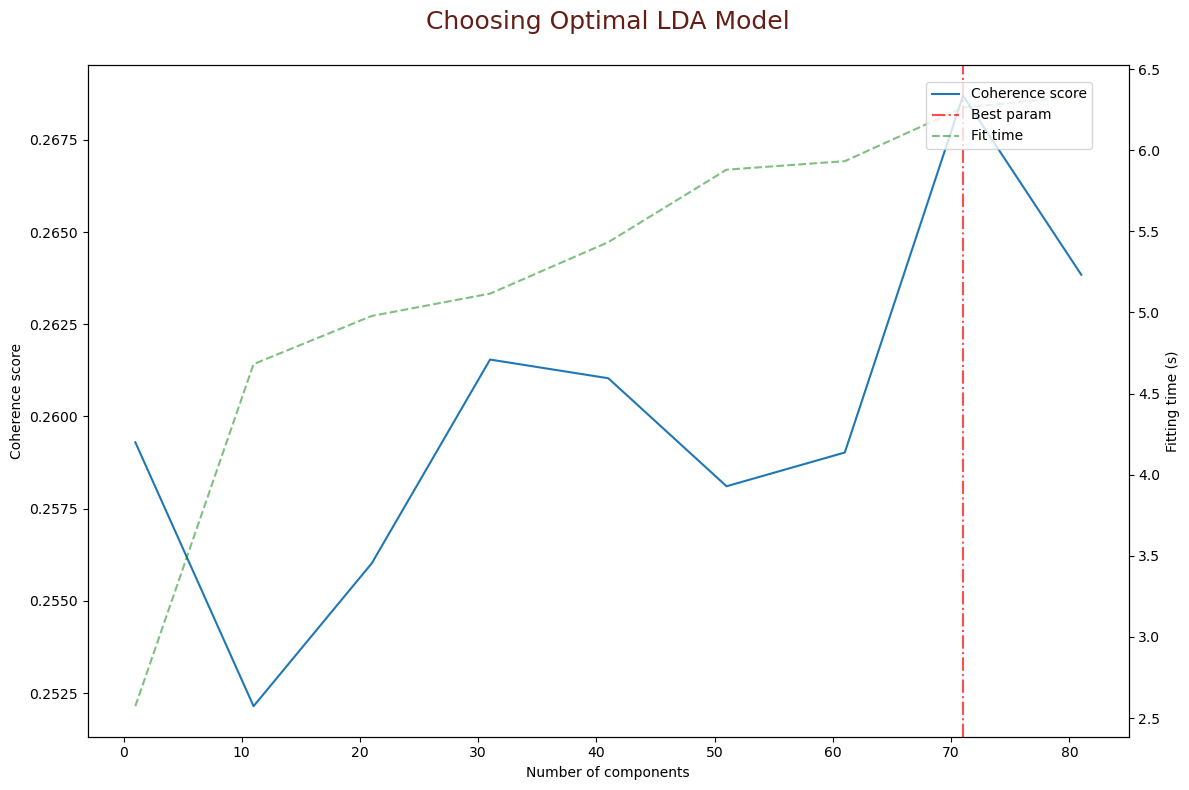

In [408]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [404]:
# Création du modèle LDA
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(data[''])

KeyError: ''

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

### Supervisée <a class="anchor" id="section_4_2"></a>